# Identifying Differentially Expressed Genes as part of progeny Pathways per celltype using scvi and pyDeseq2
- Created by: Christian Eger
- Creation date: November 11, 2024
- environment: scvi_and_pydeseq-env

## Control Flow

In [18]:
cell_type_key = "cell_compartment" # The key for the celltype annotation you want to use in adata.obs
batch_key = "batch" # The batch key used for pseudobulking along for pyDESeq and for batch integration for scvi
design_factor = "infection" # The key for the experimental conditions you want to test for in adata.obs
design_values = ("CTRL", "IAV") # Two of the values found in the design_factor and only two

rerun_pyDESeq = False
rerun_scvi = False

## Environment Setup

In [129]:
from pathlib import Path
from typing import Iterable, Iterator
from functools import reduce
from itertools import combinations, chain

import pickle
import pandas as pd
import scvi
import decoupler
import scanpy as sc
import anndata as ad
from scipy import sparse
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
import upsetplot

### Helper Functions

In [20]:
def generate_adata_subsets(adata: ad.AnnData, layer: str, key: str, values: Iterable) -> Iterator[ad.AnnData]:
    """Takes an AnnData Object and returns an iterable of AnnData Objects subset for their values in a column in either .obs or .var"""
    return (adata[getattr(adata, layer)[key] == value] for value in values)

def pseudobulk_from_adata(adata: ad.AnnData) -> ad.AnnData:
    """
    Takes an AnnData Object with n_obs x n_vars and returns an AnnData object with 1 obs x n_vars by summing along the obs dimension.
    Metadata for observations is kept, if in the original AnnData object only a single value was stored.
    """
    return ad.AnnData(
        X=sparse.csr_matrix(adata.X.toarray().sum(axis=0)),
        obs=adata.obs[filter(lambda column: len(set(adata.obs[column])) == 1, adata.obs.columns)].head(1),
        var=adata.var
    )

def run_deseq_DEG(adata: ad.AnnData, design_factor: str, inference=DefaultInference(n_cpus=8)) -> pd.DataFrame:
    """Wrapper function for pyDESeq differentially expressed gene analysis"""
    dds = DeseqDataSet(
        counts=pd.DataFrame(adata.X.toarray(), index=adata.obs_names, columns=adata.var_names),
        metadata=adata.obs,
        design_factors=design_factor,
        refit_cooks=True,
        inference=inference,
    )
    dds.deseq2()
    result = DeseqStats(dds, alpha=0.05, cooks_filter=True, independent_filter=True)
    result.summary()
    return result.results_df

def run_scvi_DEG(adata: ad.AnnData, batch_key: str, design_factor: str, design_values: tuple[str]):
    """Wrapper function for scvi differentially expressed gene analysis"""
    adata = adata.copy()
    scvi.model.SCVI.setup_anndata(
        adata,
        batch_key=batch_key
    )
    vae = scvi.model.SCVI(adata)
    vae.train()
    return vae.differential_expression(groupby=design_factor, group1=design_values[0], group2=design_values[1])

def powerset(iterable):
    """powerset([1,2,3]) → (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"""
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(1, len(s)+1))

def powerset_modified(iterable):
    """
    Same as powerset, but without the combinations between 1 and n
    powerset_modified([1,2,3]) → (1,) (2,) (3,) (1,2,3)
    """
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in (1, len(s)))


### Folder Structure

In [21]:
global_repo_data = Path.cwd() / ".." / ".." / ".data"
local_folder_data = Path.cwd() / ".data"
figures_dir = local_folder_data / "figures"
save_results_path = local_folder_data / "Pathway_DEGs_by_celltype"
save_results_path.mkdir(exist_ok=True)

### Data Loading

In [22]:
adata = sc.read_h5ad(global_repo_data / "Marburg_cell_states_locked_ctl240709.raw.h5ad")
adata

AnnData object with n_obs × n_vars = 97573 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', 'IAV_score', 'group', 'Viral_score', 'cell_type', 'cell_states', 'leiden', 'cell_compartment', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'viral_counts', 'infected_status', 'seed_labels', 'batch-scANVI'
    var: 'mt', 'ribo'
    uns: 'cell_compartment_colors', 'cell_states_colors', 'disease_colors', 'group_colors', 'infection_colors'
    obsm: 'X_scANVI', 'X_umap'

In [23]:
"""
Necessary to filter the celltypes for the ones that appear in both experimental conditions
"Epi" was removed because the low counts in the control condition exaggerates the number of DEGs
"Mixed" is removed because when training the scvi model, the sample 'CSE03_CTRL' generates the error ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 128])
"""
cell_types = reduce(set.intersection, (set(adata.obs[cell_type_key]) for adata in  generate_adata_subsets(adata, "obs", design_factor, design_values))) - {"Epi", "Mixed"}
#cell_types = cell_types[:3]
cell_types

{'Basal',
 'Ciliated',
 'Club',
 'Deuterosomal',
 'Goblet',
 'Ionocyte',
 'Secretory',
 'SupraB'}

In [24]:
net = decoupler.get_progeny(organism='human')
net

,source,target,weight,p_value
0,Androgen,TMPRSS2,11.490631,0.000000e+00
1,Androgen,NKX3-1,10.622551,2.242078e-44
2,Androgen,MBOAT2,10.472733,4.624285e-44
3,Androgen,KLK2,10.176186,1.944414e-40
4,Androgen,SARG,11.386852,2.790209e-40
...,...,...,...,...
1395,p53,CCDC150,-3.174527,7.396252e-13
1396,p53,LCE1A,6.154823,8.475458e-13
1397,p53,TREM2,4.101937,9.739648e-13
1398,p53,GDF9,3.355741,1.087433e-12


## Run DEG analyses

### pyDESeq

In [25]:
"""
Running pyDESeq on pseudobulks along samples for each celltype 
"""
pyDESeq_res_path = save_results_path / "pyDESeq_res.pkl"
if rerun_pyDESeq:

    pyDESeq_res_dict = {cell_type: run_deseq_DEG(sc.concat((pseudobulk_from_adata(adata) for adata in generate_adata_subsets(adata, "obs", batch_key, set(adata.obs[batch_key])))), design_factor=design_factor) 
                        for cell_type, adata 
                        in zip(cell_types, generate_adata_subsets(adata, "obs", cell_type_key, cell_types))}

    with open(pyDESeq_res_path, "wb") as file:
        pickle.dump(pyDESeq_res_dict, file)

else:
    with open(pyDESeq_res_path, "rb") as file:
        pyDESeq_res_dict = pickle.load(file)


### scvi

In [26]:
"""
Running scvi differential expression for each celltype
"""
scvi_res_path = save_results_path / "scvi_res.pkl"
if rerun_scvi:

    scvi_res_dict = {cell_type: run_scvi_DEG(adata, batch_key=batch_key, design_factor=design_factor, design_values=design_values) 
                     for cell_type, adata 
                     in zip(cell_types, generate_adata_subsets(adata, "obs", cell_type_key, cell_types))}

    with open(scvi_res_path, "wb") as file:
        pickle.dump(scvi_res_dict, file)
        
else:
    with open(scvi_res_path, "rb") as file:
        scvi_res_dict = pickle.load(file)

scvi_res_dict

{'Basal':         proba_de  proba_not_de  bayes_factor    scale1    scale2  \
 IFIT3     0.9764        0.0236      3.722625  0.000054  0.000875   
 MX1       0.9762        0.0238      3.713981  0.000044  0.000546   
 IFIT1     0.9746        0.0254      3.647278  0.000042  0.000675   
 IFI6      0.9730        0.0270      3.584547  0.000145  0.001865   
 XAF1      0.9712        0.0288      3.518157  0.000061  0.000377   
 ...          ...           ...           ...       ...       ...   
 SYAP1     0.3234        0.6766     -0.738190  0.000089  0.000085   
 RBM39     0.3142        0.6858     -0.780556  0.000271  0.000268   
 TMEM9B    0.2962        0.7038     -0.865459  0.000102  0.000104   
 TMCO1     0.2934        0.7066     -0.878928  0.000136  0.000131   
 TFG       0.2322        0.7678     -1.195930  0.000156  0.000158   
 
         pseudocounts  delta  lfc_mean  lfc_median   lfc_std  ...  raw_mean1  \
 IFIT3            0.0   0.25 -3.161007   -3.058482  1.760985  ...   1.435992   
 

## Plotting

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

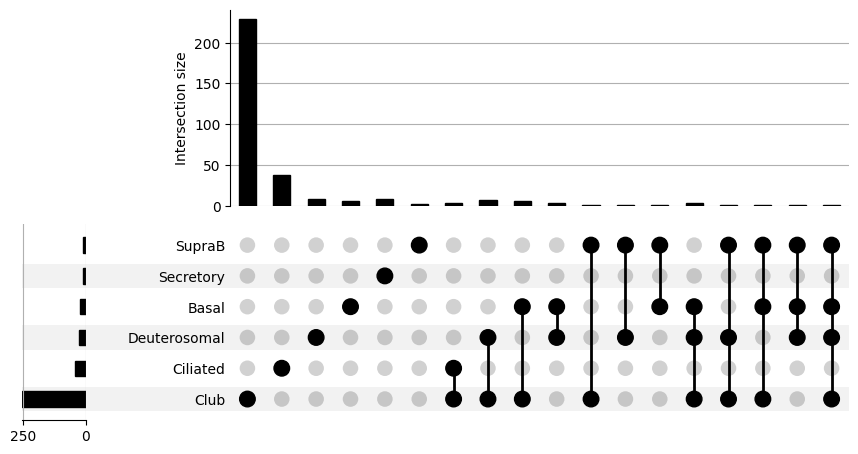

In [132]:
query_expression = "bayes_factor > 3 and abs(lfc_median) > 2.63" 
res_dict = scvi_res_dict
test = [(celltype_set, len(reduce(set.intersection, (set(res_dict[cell_type].query(query_expression).index) 
                        for cell_type 
                        in celltype_set)))) 
        for celltype_set in 
        powerset(cell_types)]
upsetplot_combinations = []
upsetplot_data = []
for celltype_set, d in test:
    if d > 0:
        upsetplot_combinations.append(list(celltype_set))
        upsetplot_data.append(d)
res = upsetplot.from_memberships(upsetplot_combinations, upsetplot_data)
upsetplot.plot(res)

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

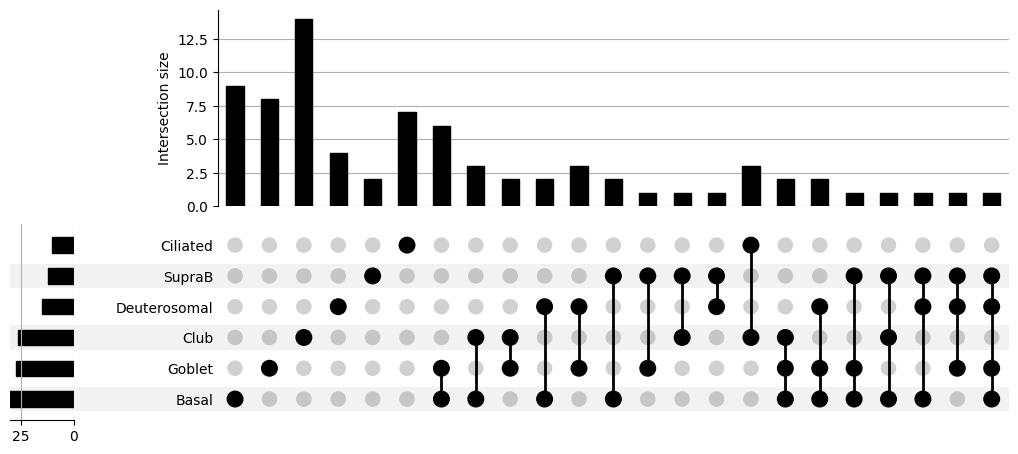

In [136]:
query_expression = "padj < 0.05 and abs(log2FoldChange) > 5" 
res_dict = pyDESeq_res_dict
test = [(celltype_set, len(reduce(set.intersection, (set(res_dict[cell_type].query(query_expression).index) 
                        for cell_type 
                        in celltype_set)))) 
        for celltype_set in 
        powerset(cell_types)]
upsetplot_combinations = []
upsetplot_data = []
for celltype_set, d in test:
    if d > 0:
        upsetplot_combinations.append(list(celltype_set))
        upsetplot_data.append(d)
res = upsetplot.from_memberships(upsetplot_combinations, upsetplot_data)
upsetplot.plot(res)